# Fermi-Hubbard Model I

In [4]:
Pkg.add("JLD")

   Resolving package versions...
   Installed MPIPreferences ──── v0.1.11
   Installed HDF5_jll ────────── v1.14.6+0
   Installed H5Zblosc ────────── v0.1.2
   Installed MicrosoftMPI_jll ── v10.1.4+3
   Installed Hwloc_jll ───────── v2.12.1+0
   Installed MPICH_jll ───────── v4.3.1+0
   Installed OpenMPI_jll ─────── v5.0.8+0
   Installed libaec_jll ──────── v1.1.3+0
   Installed Lz4_jll ─────────── v1.10.1+0
   Installed MPItrampoline_jll ─ v5.5.4+0
   Installed FileIO ──────────── v1.17.0
   Installed HDF5 ────────────── v0.17.2
   Installed Blosc_jll ───────── v1.21.7+0
   Installed JLD ─────────────── v0.13.5
   Installed Blosc ───────────── v0.7.3
    Updating `~/.julia/environments/v1.10/Project.toml`
  [4138dd39] + JLD v0.13.5
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [a74b3585] + Blosc v0.7.3
  [5789e2e9] + FileIO v1.17.0
  [c8ec2601] + H5Zblosc v0.1.2
  [f67ccb44] + HDF5 v0.17.2
  [4138dd39] + JLD v0.13.5
  [3da0fdf6] + MPIPreferences v0.1.11
  [0b7ba130] + Blo

In [5]:
using Pkg; Pkg.activate()

using KadanoffBaym

using FFTW, Interpolations
function wigner_transform_itp(x::AbstractMatrix, ts::Vector; fourier = true, ts_lin = range(first(ts), last(ts); length = length(ts)))
    itp = interpolate((ts, ts), x, Gridded(Linear()))
    return wigner_transform([itp(t1, t2) for t1 in ts_lin, t2 in ts_lin]; ts = ts_lin, fourier = fourier)
end

using LinearAlgebra, BlockArrays

using JLD

using PyPlot
# PyPlot.plt.style.use("./paper.mplstyle")
using LaTeXStrings

  Activating project at `~/.julia/environments/v1.10`


## Model

### Hamiltonian

$$
\begin{align}\begin{split}
    \hat{H} &= - J \sum_{\langle{i,\,j}\rangle}\sum_\sigma \hat{c}^{\dagger}_{i,\sigma} \hat{c}^{\phantom{\dagger}}_{i+1,\sigma} + U\sum_{i=1}^L  \hat{c}^{\dagger}_{i,\uparrow} \hat{c}^{\phantom{\dagger}}_{i,\uparrow}   \hat{c}^{\dagger}_{i,\downarrow} \hat{c}^{\phantom{\dagger}}_{i,\downarrow}, 
\end{split}\end{align}
$$

### Green functions

$$
    G^>_{\uparrow,ij}(t, t') = -i \left\langle \hat{c}^{\phantom{\dagger}}_{i,\uparrow}(t) \hat{c}^{{\dagger}}_{i,\uparrow}(t') \right\rangle\\
    G^>_{\downarrow,ij}(t, t') = -i \left\langle \hat{c}^{\phantom{\dagger}}_{i,\downarrow}(t) \hat{c}^{{\dagger}}_{i,\downarrow}(t') \right\rangle\\
$$

### Self-energies

Hartree-Fock:
$$
    \Sigma^{\mathrm{HF}}_{\uparrow,\,ij}(t, t') = {\mathrm{i}}\delta_{ij}\delta(t - t') G^<_{\downarrow,ii}(t, t)\\
    \Sigma^{\mathrm{HF}}_{\downarrow,\,ij}(t, t') = {\mathrm{i}}\delta_{ij}\delta(t - t') G^<_{\uparrow,ii}(t, t)
$$


Second-order Born approximation:
$$
    \Sigma_{ij, \uparrow}  (t, t') = U^2 G_{ij, \uparrow}(t, t') G_{ij, \downarrow}(t, t') G_{ji, \downarrow}(t', t),\\
    \Sigma_{ij, \downarrow}(t, t') = U^2 G_{ij, \downarrow}(t, t') G_{ij, \uparrow}(t, t') G_{ji, \uparrow}(t', t)
$$

## Solving

In [6]:
function integrate1(hs::Vector, t1, t2, A::GreenFunction, B::GreenFunction, C::GreenFunction; tmax=t1)
    retval = zero(A[t1,t1])

    @inbounds for k in 1:tmax
        @views LinearAlgebra.mul!(retval, A[t1, k] - B[t1, k], C[k, t2], hs[k], 1.0)
    end
    return retval
end

function integrate2(hs::Vector, t1, t2, A::GreenFunction, B::GreenFunction, C::GreenFunction; tmax=t2)
    retval = zero(A[t1,t1])

    @inbounds for k in 1:tmax
        @views LinearAlgebra.mul!(retval, A[t1, k], B[k, t2] - C[k, t2], hs[k], 1.0)
    end
    return retval
end

integrate2 (generic function with 1 method)

In [7]:
# Lattice size
L = 8

# Allocate the initial Green functions (time arguments at the end)
GL_u = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian)
GG_u = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian)
GL_d = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian)
GG_d = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian)

# Initial conditions
N_u = zeros(L)
N_d = zeros(L)

# From the paper
N_u[1:4] = [0.7, 0.0, 0.7, 0.0]
N_d[1:4] = [0.0, 0.25, 0.0, 0.25]

N_u[5:8] = [0.0, 0.4, 0.0, 0.4]
N_d[5:8] = [0.65, 0.0, 0.65, 0.0]

# From the docs
# N_u[1:4] = 0.1 .* [1, 1, 1, 1]
# N_d[1:4] = 0.1 .* [1, 1, 1, 1]

# N_u[5:8] = 0.0 .* [1, 1, 1, 1]
# N_d[5:8] = 0.0 .* [1, 1, 1, 1]

GL_u[1, 1] = 1.0im * diagm(N_u)
GG_u[1, 1] = -1.0im * (I - diagm(N_u))
GL_d[1, 1] = 1.0im * diagm(N_d)
GG_d[1, 1] = -1.0im * (I - diagm(N_d));

In [8]:
Base.@kwdef struct FermiHubbardData2B{T}
    GL_u::T
    GG_u::T
    GL_d::T
    GG_d::T

    ΣL_u::T = zero(GL_u)
    ΣG_u::T = zero(GG_u)
    ΣL_d::T = zero(GL_d)
    ΣG_d::T = zero(GG_d)
end

data = FermiHubbardData2B(GL_u=GL_u, GG_u=GG_u, GL_d=GL_d, GG_d=GG_d);

In [9]:
Base.@kwdef struct FermiHubbardModel{T}
    # interaction strength
    U::T

    # 8-site 3D cubic lattice
    h = begin
        h = BlockArray{ComplexF64}(undef_blocks, [4, 4], [4, 4])
        diag_block = [0 -1 0 -1; -1 0 -1 0; 0 -1 0 -1; -1 0 -1 0]
        setblock!(h, diag_block, 1, 1)
        setblock!(h, diag_block, 2, 2)
        setblock!(h, Diagonal(-1 .* ones(4)), 1, 2)
        setblock!(h, Diagonal(-1 .* ones(4)), 2, 1)

        h |> Array
    end

    H_u = h
    H_d = h
end

# Relatively small interaction parameter
const U₀ = 0.25
model = FermiHubbardModel(U = t -> U₀);

In [10]:
# Right-hand side for the "vertical" evolution
function fv!(model, data, out, times, h1, h2, t, t′)
    # Unpack data and model
    (; GL_u, GG_u, GL_u, GG_d, ΣL_u, ΣG_u, ΣL_d, ΣG_d) = data
    (; H_u, H_d, U) = model

    # Real-time collision integrals
    ∫dt1(A, B, C) = integrate1(h1, t, t′, A, B, C)
    ∫dt2(A, B, C) = integrate2(h2, t, t′, A, B, C)
    
    # The interaction varies as a function of the forward time (t+t')/2
    U_t = U((times[t] + times[t′])/2)
    
    # Hartree-Fock self-energies
    ΣHF_u(t, t′) = im * U_t * Diagonal(GL_d[t, t])
    ΣHF_d(t, t′) = im * U_t * Diagonal(GL_u[t, t])
    
    # Equations of motion
    out[1] = -1.0im * ((H_u + ΣHF_u(t, t′)) * GL_u[t, t′] + 
            ∫dt1(ΣG_u, ΣL_u, GL_u) + ∫dt2(ΣL_u, GL_u, GG_u)
        )

    out[2] = -1.0im * ((H_u + ΣHF_u(t, t′)) * GG_u[t, t′] + 
            ∫dt1(ΣG_u, ΣL_u, GG_u) + ∫dt2(ΣG_u, GL_u, GG_u)
        )

    out[3] = -1.0im * ((H_d + ΣHF_d(t, t′)) * GL_d[t, t′] + 
            ∫dt1(ΣG_d, ΣL_d, GL_d) + ∫dt2(ΣL_d, GL_d, GG_d)
        )

    out[4] = -1.0im * ((H_d + ΣHF_d(t, t′)) * GG_d[t, t′] +
            ∫dt1(ΣG_d, ΣL_d, GG_d) + ∫dt2(ΣG_d, GL_d, GG_d)
        )  
    
    return out
end

# Right-hand side for the "diagonal" evolution
function fd!(model, data, out, times, h1, h2, t, t′)
    fv!(model, data, out, times, h1, h2, t, t)
    out .-= adjoint.(out)
end

fd! (generic function with 1 method)

In [11]:
# Callback function for the self-energies
function second_Born!(model, data, times, _, _, t, t′)
    # Unpack data and model
    (; GL_u, GG_u, GL_d, GG_d, ΣL_u, ΣG_u, ΣL_d, ΣG_d) = data
    (; U) = model
        
    # Resize self-energies when Green functions are resized    
    if (n = size(GL_u, 3)) > size(ΣL_u, 3)
        resize!(ΣL_u, n)
        resize!(ΣG_u, n)
        resize!(ΣL_d, n)
        resize!(ΣG_d, n)        
    end
    
    # The interaction varies as a function of the forward time (t+t')/2
    U_t = U((times[t] + times[t′])/2)
    
    # Define the self-energies
    ΣL_u[t, t′] = U_t^2 .* GL_u[t, t′] .* GL_d[t, t′] .* transpose(GG_d[t′, t])
    ΣL_d[t, t′] = U_t^2 .* GL_u[t, t′] .* GL_d[t, t′] .* transpose(GG_u[t′, t])
    
    ΣG_u[t, t′] = U_t^2 .* GG_u[t, t′] .* GG_d[t, t′] .* transpose(GL_d[t′, t])
    ΣG_d[t, t′] = U_t^2 .* GG_u[t, t′] .* GG_d[t, t′] .* transpose(GL_u[t′, t])
end

second_Born! (generic function with 1 method)

In [12]:
tmax = 32;
atol = 1e-8
rtol = 1e-6;

In [13]:
@time sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> fd!(model, data, x...),
    [data.GL_u, data.GG_u, data.GL_d, data.GG_d],
    (0.0, tmax);
    callback = (x...) -> second_Born!(model, data, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false)
);

t: 0.0
t: 0.0
t: 0.0
t: 0.0
t: 8.548176969997932e-5
t: 0.00016801188879005504
t: 0.0002650495972796439
t: 0.00037531885268426795
t: 0.0009266651297073883
t: 0.0014228767790281966
t: 0.0039039350256322375
t: 0.016309226258652443
t: 0.02747398836837063
t: 0.058287492048922036
t: 0.11086371753919738
t: 0.1581823204804452
t: 0.20548765817758738
t: 0.25407422909357125
t: 0.3019560756927735
t: 0.3546132920822852
t: 0.40200478683284574
t: 0.4575086173713532
t: 0.5209451339098733
t: 0.5780379987945414
t: 0.6296033735722344
t: 0.6804374109066831
t: 0.7316491286977714
t: 0.7839044155331343
t: 0.8360277447211188
t: 0.8864088498511896
t: 0.9377681570084697
t: 0.9893465059975249
t: 1.0429914304357464
t: 1.0990408674051846
t: 1.1578986174694976
t: 1.2218103096725286
t: 1.2882327363218078
t: 1.3565958963551483
t: 1.4256448697701871
t: 1.4892153917908644
t: 1.4892153917908644
t: 1.5439566168910706
t: 1.59520116143549
t: 1.6444678641331887
t: 1.6974033074947488
t: 1.7526164247645895
t: 1.81293107219871

In [25]:
save("FH_3D_sol_U_"*string(U₀)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld", "solution", sol)

## Example plots

### Load data

In [26]:
loaded_sol = load("FH_3D_sol_U_"*string(U₀)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld");

In [27]:
import PyCall
const is = PyCall.pyimport("mpl_toolkits.axes_grid1.inset_locator")
const inset_axes = is.inset_axes;

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


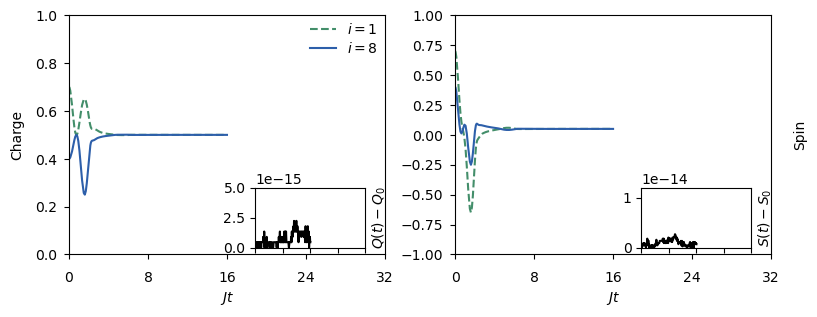

In [28]:
let
    num_points = loaded_sol["solution"].t |> length
    
    xpad = 8
    ypad = 5

    fig, (ax1, ax2) = subplots(1, 2, figsize = (8, 3))
    idx_1 = 1
    idx_2 = 8

    ax1.plot(loaded_sol["solution"].t, [imag(data.GL_u.data[idx_1, idx_1, k, k] .+ data.GL_d.data[idx_1, idx_1, k, k]) for k = 1:num_points], 
        label = "\$ i=1\$", lw=1.5, ls = "--", c = "#438E6A")

    ax1.plot(loaded_sol["solution"].t, [imag(data.GL_u.data[idx_2, idx_2, k, k] .+ data.GL_d.data[idx_2, idx_2, k, k]) for k = 1:num_points], 
        label = "\$ i=8\$", lw=1.5, ls = "-", c = "#2D5FAA")

    ax1.set_xlim(0, tmax)
    ax1.set_xticks([0, 8, 16, 24, 32])
    ax1.set_ylim(-0, 1)
    ax1.set_xlabel("\$J t\$")
    ax1.set_ylabel("Charge", labelpad = 8)
    ax1.xaxis.set_tick_params(pad = xpad)
    ax1.yaxis.set_tick_params(pad = ypad)
    ax1.legend(loc = "best", handlelength = 1.9, frameon = false, borderpad = 0, labelspacing = 0.25)

    # ax2 = subplot(122)

    ax2.plot(loaded_sol["solution"].t, [imag(data.GL_u.data[idx_1, idx_1, k, k] .- data.GL_d.data[idx_1, idx_1, k, k]) for k = 1:num_points], 
        label = "\$ i=2\$", lw=1.5, ls = "--", c = "#438E6A")

    ax2.plot(loaded_sol["solution"].t, [imag(data.GL_u.data[idx_2, idx_2, k, k] .- data.GL_d.data[idx_2, idx_2, k, k]) for k = 1:num_points], 
        label = "\$ i=2\$",  lw=1.5, ls = "-", c = "#2D5FAA")

    ax2.set_xlim(0, tmax)
    ax2.set_ylim(-1, 1)
    ax2.set_xticks([0, 8, 16, 24, 32])
    ax2.set_xlabel("\$J t\$")
    ax2.set_ylabel("Spin", labelpad = 16)
    ax2.xaxis.set_tick_params(pad = xpad)
    ax2.yaxis.set_tick_params(pad = ypad)
    ax2.set_axisbelow(false)
    ax2.yaxis.set_label_position("right")

    axins1 = inset_axes(ax1, width=1.1 * 1.0, height=0.8*3/4, loc=4, 
        bbox_to_anchor=(0.96, .0, .0, .0),
        bbox_transform=ax1.transAxes)

    axins1.plot(loaded_sol["solution"].t, [(tr(data.GL_u.data[:, :, k, k]) |> imag) .+ (tr(data.GL_d.data[:, :, k, k]) |> imag) for k = 1:num_points] 
        .- sum(N_u .+ N_d)  .|> abs, 
        label = "\$ c \$", ls = "-", c = "k")
    axins1.set_xlim(0, tmax)
    axins1.set_xticks([0, 8, 16, 24, 32])
    axins1.set_xticklabels([])
    axins1.set_yticks([k for k in 0:0.5:1] .* 5e-15)
    axins1.set_ylim([0.0, 1] .* 5e-15)
    axins1.set_ylabel(L"Q(t) - Q_0", fontdict = Dict(:fontsize=>10))
    axins1.tick_params(axis="y", labelsize=10)
    axins1.yaxis.get_offset_text().set_fontsize(10)
    axins1.yaxis.set_label_position("right")

    axins2 = inset_axes(ax2, width=1.1 * 1.0, height=0.8*3/4, loc=4, 
        bbox_to_anchor=(0.96, .0, .0, .0),
        bbox_transform=ax2.transAxes)

    axins2.plot(loaded_sol["solution"].t, [(tr(data.GL_u.data[:, :, k, k]) |> imag) .- (tr(data.GL_d.data[:, :, k, k]) |> imag) for k = 1:num_points] 
        .- sum(N_u .- N_d) .|> abs, 
        label = "\$ c \$", ls = "-", c = "k")
    axins2.set_xlim(0, tmax)
    axins2.set_xticks([0, 8, 16, 24, 32])
#     axins2.set_yticks([k for k in 0:0.5:1] .* 3e-15)
    axins2.set_xticklabels([])
    axins2.set_ylim([0.0, 1] .* 12e-15)
    axins2.set_ylabel(L"S(t) - S_0", fontdict = Dict(:fontsize=>10))
    axins2.tick_params(axis="y", labelsize=10)
    axins2.yaxis.get_offset_text().set_fontsize(10)
    axins2.yaxis.set_label_position("right")

    tight_layout(pad = 0.1, w_pad = 0.5, h_pad = 0)
#     savefig("fermi_hubbard_T.pdf")
end

In [29]:
function meshgrid(xin,yin)
  nx=length(xin)
  ny=length(yin)
  xout=zeros(ny,nx)
  yout=zeros(ny,nx)
  for jx=1:nx
      for ix=1:ny
          xout[ix,jx]=xin[jx]
          yout[ix,jx]=yin[ix]
      end
  end
  return (x=xout, y=yout)
end

Y, X = meshgrid(loaded_sol["solution"].t, loaded_sol["solution"].t);

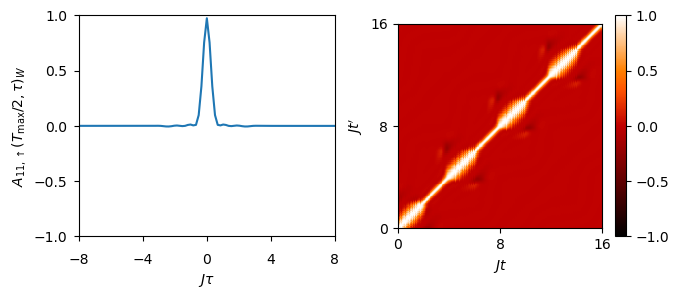

In [30]:
let
    # quantum number to look at
    idx = 1
    shift = 0

    ρτ, (τs, ts) = wigner_transform_itp((data.GG_u.data[idx, idx, :, :] - data.GL_u.data[idx, idx, :, :]), 
        loaded_sol["solution"].t[1+shift:end-shift], fourier=false);
    ρω, (ωs, ts) = wigner_transform_itp((data.GG_u.data[idx, idx, :, :] - data.GL_u.data[idx, idx, :, :]), 
        loaded_sol["solution"].t[1+shift:end-shift], fourier=true);
    cmap = "gist_heat";
    
    xpad = 8
    ypad = 5
    
    figure(figsize=(7, 3))
    
    t_scale = 1
    vmin = -1.0
    vmax = 1.0

    center = floor(length(ts) / 2) |> Int

    ax = subplot(121)
    plot(τs, -ρτ[:, center] |> imag, ls="-", c="C0", lw=1.5)
    ax.set_xlabel("\$J \\tau\$")
    ax.set_xlim(-tmax / 2, t_scale * tmax / 2)
    ax.set_ylim(-1, 1)
    ax.set_xticks([-tmax/2, -tmax/4, 0, tmax/4, tmax/2])
    ax.xaxis.set_tick_params(pad=xpad)
    ax.yaxis.set_tick_params(pad=ypad)
    ax.set_ylabel("\$  A_{11, \\uparrow}(T_{\\mathrm{max}}/2, \\tau)_W \$")

    ax = subplot(122)
    heatmap = ax.pcolormesh(X, Y, imag(data.GL_u.data[1, 1, :, :]) .- imag(data.GG_u.data[1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
    heatmap.set_edgecolor("face")
    ax.set_aspect("equal")
    cbar = colorbar(mappable=heatmap)
    cbar.formatter.set_powerlimits((0, 0))
    ax.set_xlabel("\$J t\$")
    ax.set_ylabel("\$J t'\$")
    ax.set_xlim(0, t_scale * tmax)
    ax.set_ylim(0, t_scale * tmax)
    ax.set_xticks(t_scale .* [0, tmax/2, tmax])
    ax.set_yticks(t_scale .* [0, tmax/2, tmax])

    tight_layout(pad=0.75, w_pad=0.5, h_pad=0)

    # savefig("fermi_hubbard_example_two_times.pdf")
end

## Quench

In [31]:
const U₀ = 10.
model = FermiHubbardModel(U = t -> -U₀ * [(-1)^k * (1 + exp(-20(t - 2k)))^(-1) for k in 1:tmax-1] |> sum);

In [32]:
tmax = 16;
atol = 1e-5
rtol = 1e-3

@time sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> fd!(model, data, x...),
    [data.GL_u, data.GG_u, data.GL_d, data.GG_d],
    (0.0, tmax);
    callback = (x...) -> second_Born!(model, data, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false)
);

t: 0.0
t: 0.0
t: 0.0027178003448082204
t: 0.005334469768343318
t: 0.008411589655946995
t: 0.011914880447532153
t: 0.02943133440545794
t: 0.045196142967591155
t: 0.12402018577825721
t: 0.3020425494685869
t: 0.3020425494685869
t: 0.43517519420462153
t: 0.43517519420462153
t: 0.5388949721313256
t: 0.635443556589441
t: 0.7424712645416764
t: 0.8404815039326536
t: 0.9365884903541986
t: 1.0543945355011304
t: 1.181355348120413
t: 1.323447587537529
t: 1.4915833224818447
t: 1.4915833224818447
t: 1.4915833224818447
t: 1.5985490078556321
t: 1.698629268502965
t: 1.797335024671967
t: 1.8992414833203175
t: 2.0067129616567505
t: 2.0067129616567505
t: 2.0997643865986824
t: 2.0997643865986824
t: 2.0997643865986824
t: 2.157024408542551
t: 2.157024408542551
t: 2.2032580320135
t: 2.246541762732868
t: 2.290196579646553
t: 2.3343838669224377
t: 2.3801708225951637
t: 2.421379082700617
t: 2.469848041798729
t: 2.5340621310790863
t: 2.5918548114314075
t: 2.6575706907420855
t: 2.7283941371676095
t: 2.803789701795

In [33]:
save("quenched_FH_3D_sol_U_"*string(U₀)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld", "solution", sol)

In [34]:
loaded_sol = load("quenched_FH_3D_sol_U_"*string(U₀)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld");

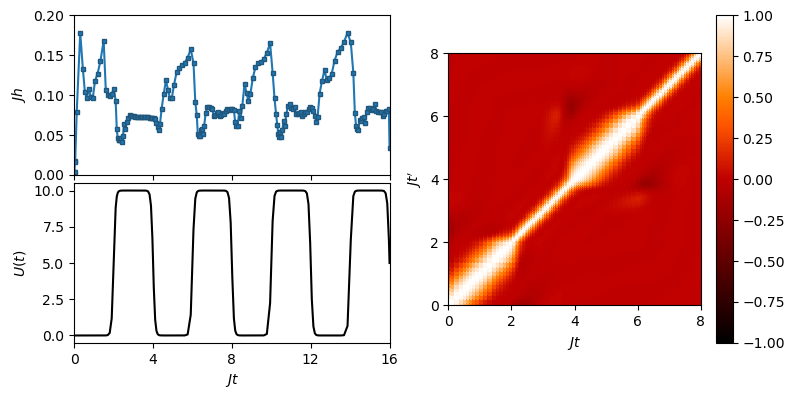

In [35]:
let
    tt = loaded_sol["solution"].t
    fig = figure(figsize=(8, 4))
    ax = subplot(221)
    ax.plot(tt[2:end], map(t -> t[2] - t[1], zip(tt[1:end-1], tt[2:end])), "-s", ms=3, markeredgecolor="#22577c")
    ax.set_xticks([0, 4, 8, 12, 16])
    xlim(0, tmax)
    ylim(0, 0.2)
    ax.set_xticklabels([])
    ylabel("\$J h\$")

    ax = subplot(223)
    ax.plot(tt, model.U.(tt), "-k")
    ax.set_xticks([0, 4, 8, 12, 16])
    xlim(0, tmax)
    xlabel("\$Jt\$")
    ylabel("\$U(t)\$")

    # quantum number to look at
    idx = 1

    ρτ, (τs, ts) = wigner_transform_itp((data.GG_u.data[idx, idx, :, :] - data.GL_u.data[idx, idx, :, :]), 
        loaded_sol["solution"].t[1:end], fourier=false);
    ρω, (ωs, ts) = wigner_transform_itp((data.GG_u.data[idx, idx, :, :] - data.GL_u.data[idx, idx, :, :]), 
        loaded_sol["solution"].t[1:end], fourier=true);

    t_scale = 1
    ω_scale = 1;

    function meshgrid(xin,yin)
      nx=length(xin)
      ny=length(yin)
      xout=zeros(ny,nx)
      yout=zeros(ny,nx)
      for jx=1:nx
          for ix=1:ny
              xout[ix,jx]=xin[jx]
              yout[ix,jx]=yin[ix]
          end
      end
      return (x=xout, y=yout)
    end

    Y, X = meshgrid(loaded_sol["solution"].t, loaded_sol["solution"].t);

    cmap = "gist_heat";

    # fig = figure(figsize=(7, 3))
    t_scale = 1
    vmin = -1.0
    vmax = 1.0

    ax = subplot(122)
    heatmap = ax.pcolormesh(X, Y, imag(data.GL_u.data[1, 1, :, :]) .- imag(data.GG_u.data[1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
    heatmap.set_edgecolor("face")
    ax.set_aspect("equal")
    cbar = colorbar(mappable=heatmap)
    cbar.formatter.set_powerlimits((0, 0))
    ax.set_xlabel("\$J t\$")
    ax.set_ylabel("\$J t'\$")
    ax.set_xlim(0, t_scale * tmax)
    ax.set_ylim(0, t_scale * tmax)
    ax.set_xlim(0, t_scale * 8)
    ax.set_ylim(0, t_scale * 8)

    ax.set_xticks(t_scale .* [0, 2, 4, 6, 8])
    ax.set_yticks(t_scale .* [0, 2, 4, 6, 8])

    tight_layout(pad=0.75, w_pad=0.5, h_pad=0)
#     savefig("quenched_fermi_hubbard_example_two_times.pdf")
    fig
end;